In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
#Download dataset from kaggle
!kaggle competitions download -c dog-breed-identification

100% 691M/691M [00:32<00:00, 23.6MB/s]
100% 691M/691M [00:32<00:00, 22.3MB/s]


In [3]:
#Unzipping the dataset
import zipfile
zip_ref=zipfile.ZipFile('/content/dog-breed-identification.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization,Flatten,Dense,BatchNormalization,Activation,Dropout
from keras import Sequential
from keras.utils import img_to_array, array_to_img, load_img,image_dataset_from_directory
import os
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# Extract features using InceptionV3
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from keras.models import Model
import gc

In [2]:
label_df = pd.read_csv('/content/labels.csv')

print('Training set: {}'.format(label_df.shape))

Training set: (10222, 2)


In [3]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
#Get the no of unique breeds
label_df.breed.nunique()

120

In [5]:
label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [6]:
#Create list of alphabetically sorted labels.
classes = sorted(list(set(label_df['breed'])))
n_classes = len(classes)
print('Total unique breed {}'.format(n_classes))


#Map each label string to an integer label.
class_to_num = dict(zip(classes, range(n_classes)))
class_to_num

Total unique breed 120


{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [7]:
home_path='/content/train/'

(375, 500, 3) 255.0 0.0


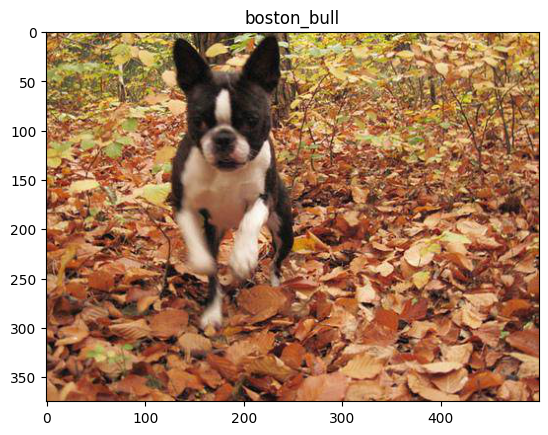

In [8]:
#Read a sample image and check the dimensions of the image
img_name=label_df['id'][0]+'.jpg'
img_path=os.path.join(home_path,img_name)
img=load_img(img_path)
plt.title(label_df['breed'][0])
plt.imshow(img)
img_arr=img_to_array(img)
print(img_arr.shape,np.max(img_arr),np.min(img_arr))

In [9]:
input_shape = (331,331,3)

def images_to_array(directory, label_dataframe, target_size = input_shape):

    image_labels = label_dataframe['breed']
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]],dtype=np.uint8) #as we have huge data and limited ram memory. uint8 takes less memory
    y = np.zeros([len(label_dataframe),1],dtype = np.uint8)

    for ix, image_name in enumerate(tqdm(label_dataframe['id'].values)):
        img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = target_size)
        images[ix] = img
        del img
        #Get the corresponding dog breed name for the image from csv
        dog_breed = image_labels[ix]
        #get the numerical code for each breed from the dictionary
        y[ix] = class_to_num[dog_breed]
    #One hot encode the numerical values for breed
    y = to_categorical(y)

    return images, y

In [10]:
import time
t = time.time()
#Call the function
X, y = images_to_array(home_path, label_df)

print('runtime in seconds: {}'.format(time.time() - t))

100%|██████████| 10222/10222 [00:40<00:00, 250.96it/s]

runtime in seconds: 40.73960208892822


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7155, 331, 331, 3) (7155, 120)
(3067, 331, 331, 3) (3067, 120)


In [12]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_accuracy', factor=.01, patience=3, min_lr=1e-5,verbose = 1)

#Prepare call backs
EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [13]:
# Hyperparameters
batch_size= 128
epochs=25
learn_rate=.001
sgd=SGD(learning_rate=learn_rate, momentum=0.9, nesterov=False)
adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

In [14]:
#function to extract features from the dataset by a given pretrained model
img_size = (331,331,3)

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    feature_extractor.save('feature_Extractor.h5')
    #Extract feature.
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [15]:
# Extract features using InceptionV3
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X_train)

print('Inception feature maps shape', inception_features.shape)

224/224 [==============================] - 110s 440ms/step
Feature maps shape:  (7155, 2048)
Inception feature maps shape (7155, 2048)


In [16]:
del X, X_train #to free up some ram memory
gc.collect()

27193

In [17]:
#Prepare Deep net

model = Sequential()
# model.add(Dense(1028,input_shape=(final_features.shape[1],)))
model.add(Dropout(0.7,input_shape=(inception_features.shape[1],)))
model.add(Dense(n_classes,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Training the model.
history = model.fit(inception_features, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=[lrr, EarlyStop])

Epoch 1/25
45/45 [==============================] - 1s 9ms/step - loss: 3.6117 - accuracy: 0.3047 - val_loss: 1.9023 - val_accuracy: 0.8372 - lr: 0.0010
Epoch 2/25
45/45 [==============================] - 0s 5ms/step - loss: 1.3694 - accuracy: 0.7825 - val_loss: 0.7728 - val_accuracy: 0.9001 - lr: 0.0010
Epoch 3/25
45/45 [==============================] - 0s 5ms/step - loss: 0.7068 - accuracy: 0.8639 - val_loss: 0.5085 - val_accuracy: 0.9050 - lr: 0.0010
Epoch 4/25
45/45 [==============================] - 0s 5ms/step - loss: 0.4997 - accuracy: 0.8906 - val_loss: 0.4151 - val_accuracy: 0.9085 - lr: 0.0010
Epoch 5/25
45/45 [==============================] - 0s 5ms/step - loss: 0.4099 - accuracy: 0.9064 - val_loss: 0.3743 - val_accuracy: 0.9057 - lr: 0.0010
Epoch 6/25
45/45 [==============================] - 0s 5ms/step - loss: 0.3574 - accuracy: 0.9126 - val_loss: 0.3416 - val_accuracy: 0.9119 - lr: 0.0010
Epoch 7/25
45/45 [==============================] - 0s 4ms/step - loss: 0.3139 - a

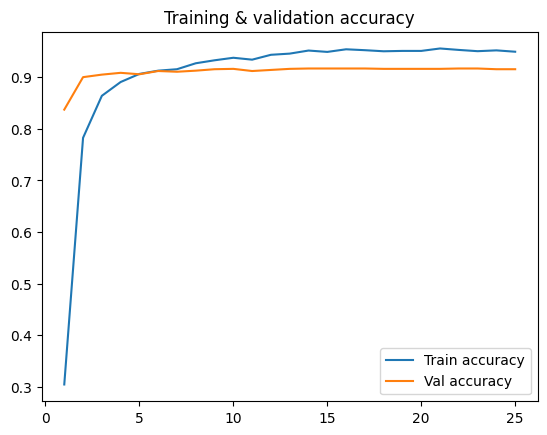

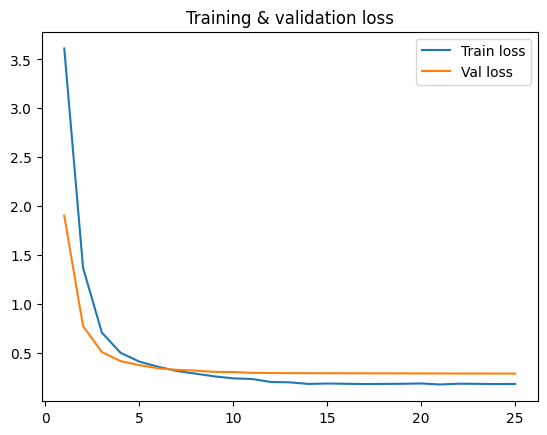

In [18]:
# Plot result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy
plt.plot(epochs, acc, label='Train accuracy')
plt.plot(epochs, val_acc, label='Val accuracy')
plt.title('Training & validation accuracy')
plt.legend()

# Loss
plt.figure()
plt.plot(epochs, loss, label='Train loss')
plt.plot(epochs, val_loss, label='Val loss')
plt.title('Training & validation loss')
plt.legend()
plt.show()

In [19]:
del inception_features
gc.collect()

9153

In [20]:
#Save model
model.save('model_dogbreedClassfn.h5')

In [21]:
#Load the saved model
from keras.models import load_model
saved_model=load_model('/content/model_dogbreedClassfn.h5')
feature_extractor=load_model('/content/feature_Extractor.h5')

In [22]:
#Extract test data features.
def extract_features(data):
    inception_features = get_features(InceptionV3, inception_preprocessor, img_size, data)
    print('Inception feature maps shape', inception_features.shape)
    return inception_features

test_features = extract_features(X_test)

96/96 [==============================] - 18s 178ms/step
Feature maps shape:  (3067, 2048)
Inception feature maps shape (3067, 2048)


In [23]:
y_pred = saved_model.predict(test_features)

96/96 [==============================] - 0s 2ms/step


In [24]:
from sklearn.metrics import accuracy_score

y_test_indices = np.argmax(y_test, axis=1)
y_pred_indices = np.argmax(y_pred, axis=1)

#get accuracy score for test dataset
accuracy_score(y_test_indices, y_pred_indices)

0.912292142158461

In [25]:
#Reverse the breed: indexno dictionary
breed_names={y:x for x,y in class_to_num.items()}
breed_names

{0: 'affenpinscher',
 1: 'afghan_hound',
 2: 'african_hunting_dog',
 3: 'airedale',
 4: 'american_staffordshire_terrier',
 5: 'appenzeller',
 6: 'australian_terrier',
 7: 'basenji',
 8: 'basset',
 9: 'beagle',
 10: 'bedlington_terrier',
 11: 'bernese_mountain_dog',
 12: 'black-and-tan_coonhound',
 13: 'blenheim_spaniel',
 14: 'bloodhound',
 15: 'bluetick',
 16: 'border_collie',
 17: 'border_terrier',
 18: 'borzoi',
 19: 'boston_bull',
 20: 'bouvier_des_flandres',
 21: 'boxer',
 22: 'brabancon_griffon',
 23: 'briard',
 24: 'brittany_spaniel',
 25: 'bull_mastiff',
 26: 'cairn',
 27: 'cardigan',
 28: 'chesapeake_bay_retriever',
 29: 'chihuahua',
 30: 'chow',
 31: 'clumber',
 32: 'cocker_spaniel',
 33: 'collie',
 34: 'curly-coated_retriever',
 35: 'dandie_dinmont',
 36: 'dhole',
 37: 'dingo',
 38: 'doberman',
 39: 'english_foxhound',
 40: 'english_setter',
 41: 'english_springer',
 42: 'entlebucher',
 43: 'eskimo_dog',
 44: 'flat-coated_retriever',
 45: 'french_bulldog',
 46: 'german_sheph

In [26]:
#Save the dictionary as a .pkl file
import pickle
pickle.dump(breed_names, open("breed_names.pkl", "wb"))


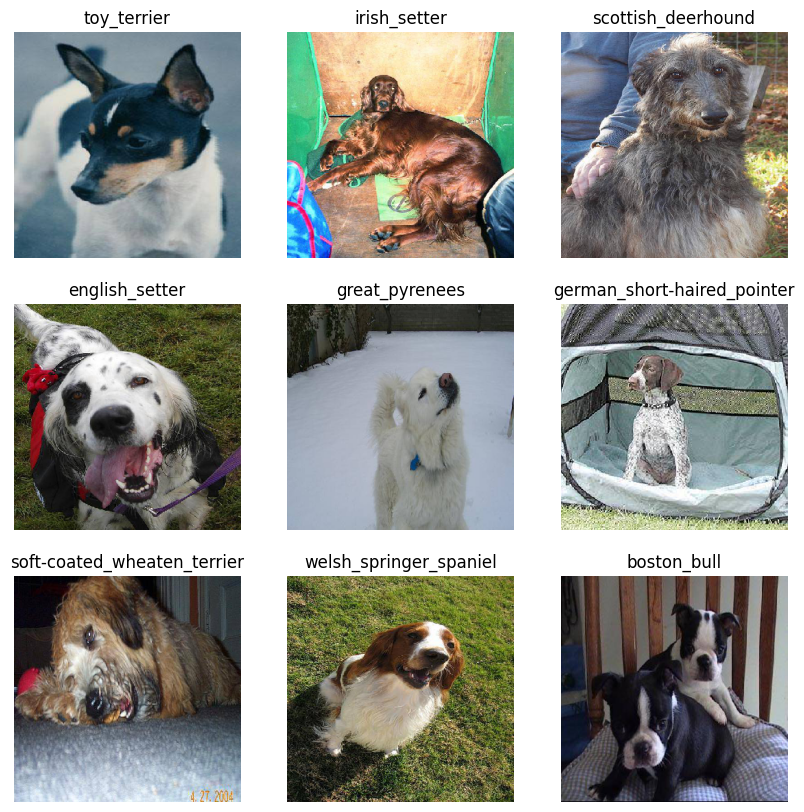

In [27]:
#Display 9 images of test dataset with corresponding predicted labels
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_test[i])
  plt.title(breed_names[y_pred_indices[i]])
  plt.axis("off")

## Test the model

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Lambda, Input, GlobalAveragePooling2D
from keras.models import load_model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
import pickle
import cv2

In [29]:
# Load the breed names dictionary back from the pickle file.
breed_names = pickle.load(open("/content/breed_names.pkl", "rb"))
#Loading the Model
classfn_model = load_model('/content/model_dogbreedClassfn.h5')
feature_extractor=load_model('/content/feature_Extractor.h5')
img_size = (331,331,3)

In [30]:
breed_names

{0: 'affenpinscher',
 1: 'afghan_hound',
 2: 'african_hunting_dog',
 3: 'airedale',
 4: 'american_staffordshire_terrier',
 5: 'appenzeller',
 6: 'australian_terrier',
 7: 'basenji',
 8: 'basset',
 9: 'beagle',
 10: 'bedlington_terrier',
 11: 'bernese_mountain_dog',
 12: 'black-and-tan_coonhound',
 13: 'blenheim_spaniel',
 14: 'bloodhound',
 15: 'bluetick',
 16: 'border_collie',
 17: 'border_terrier',
 18: 'borzoi',
 19: 'boston_bull',
 20: 'bouvier_des_flandres',
 21: 'boxer',
 22: 'brabancon_griffon',
 23: 'briard',
 24: 'brittany_spaniel',
 25: 'bull_mastiff',
 26: 'cairn',
 27: 'cardigan',
 28: 'chesapeake_bay_retriever',
 29: 'chihuahua',
 30: 'chow',
 31: 'clumber',
 32: 'cocker_spaniel',
 33: 'collie',
 34: 'curly-coated_retriever',
 35: 'dandie_dinmont',
 36: 'dhole',
 37: 'dingo',
 38: 'doberman',
 39: 'english_foxhound',
 40: 'english_setter',
 41: 'english_springer',
 42: 'entlebucher',
 43: 'eskimo_dog',
 44: 'flat-coated_retriever',
 45: 'french_bulldog',
 46: 'german_sheph

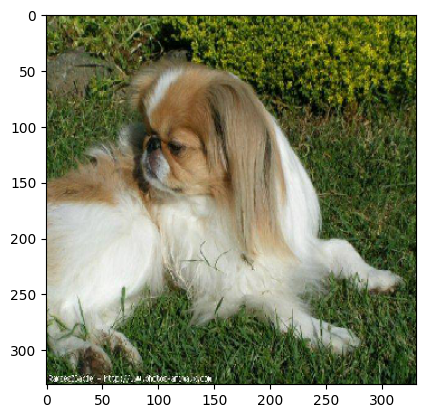

In [55]:
#img_path='/content/beagle_dog.jpg'
#img_path='/content/sib_husk.jpg'
#img_path='/content/train/000bec180eb18c7604dcecc8fe0dba07.jpg'
img_path='/content/test/000621fb3cbb32d8935728e48679680e.jpg'
image=load_img(img_path,target_size=img_size)
plt.imshow(image)

In [56]:
#Extract test data features.
def get_features(model_name, model_preprocessor, input_size, data):
    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)

    #Extract feature.
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [58]:
img_arr=img_to_array(image)
#Resizing the image
#img_arr = np.resize(img_arr, img_size)
#Convert image to 4 Dimension
img_arr=np.expand_dims(img_arr, 0)
#inception_features = get_features(InceptionV3, preprocess_input, img_size, img_arr)
inception_features=feature_extractor.predict(img_arr)

#Make Prediction
Y_pred = classfn_model.predict(inception_features)
result = breed_names[np.argmax(Y_pred)]
result

1/1 [==============================] - 0s 19ms/step


'japanese_spaniel'